In [30]:
import numpy as np
import astropy.units as u
from astropy import constants as const
from scipy.integrate import quad
import matplotlib.pyplot as plt 
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [39]:
H0 = 70
Omega_M = 0.3
Omega_lambda = 0.7
w = -1
M = -18.3  # Absolute magnitude supernova type 1a    this is a free paramters, dont know what this means

initial_params = [H0, Omega_M, Omega_lambda, w, M]

In [32]:
def H_inv(z, H0, Omega_M, Omega_lambda, w):
    '''
    1/H(z) for a given cosmology.
    '''
    return 1/(H0*np.sqrt((Omega_M*(1+z)**3)+(Omega_lambda*(1+z)**(3*(1+w)))))

def luminosity_distance(z, H0, Omega_M, Omega_lambda, w):
    '''
    Luminosity distance in Mpc for a given cosmological model of a flat universe.
    '''
    c = const.c.to(u.km/u.s).value
    
    d_L = []
    
    for z_val in z:
        integral = quad(H_inv, 0, z_val, args=(H0, Omega_M, Omega_lambda, w))
        d_L.append(integral[0] * (1+z_val) * c)
    
    return np.array(d_L)

def angular_distance(z, H0, Omega_M, Omega_lambda, w):
    '''
    Angular diameter distance in Mpc for a given cosmological model of a flat universe.
    '''

    d_A = luminosity_distance(z, H0, Omega_M, Omega_lambda, w)
    
    return d_A/(1+z)**2

def luminosity(P_bolo, z, H0, Omega_M, Omega_lambda, w):
    '''
    Luminosity from bolometric flux at peak luminosity.
    '''
    
    d_L = luminosity_distance(z, H0, Omega_M, Omega_lambda, w)*u.Mpc
    
    return (P_bolo*4*np.pi*(d_L.to(u.cm))**2).value

def luminosity_distance_GRB(L, P_bolo):
    '''
    Inverse of luminosity defined above.
    '''
    dL_GRB = np.sqrt(L / (4 * np.pi * P_bolo))*u.cm
    
    return(dL_GRB.to(u.Mpc).value)

def distance_modulus_dL(dL):
    '''
    Distance modulus from the luminosity distance.
    '''
    return 25 + 5 * np.log10(dL)

def L_Epeak(z, E_peak, params):
    log_L = params[0] + params[1] * np.log10(E_peak*(1+z)/300)
    return (10**log_L)

In [33]:
def mod_z_SNIa():
    '''
    Getting the SNIa data.
    '''
    # SNIa data
    z_SNI, err_z_SNI, m_SNI, err_m_SNI = np.loadtxt(f'lcparam_full_long_zhel.txt', skiprows=1, usecols=(1, 3, 4, 5), unpack=True)
    
    return z_SNI, m_SNI

def mod_z_GRB(initial_params):
    '''
    Getting the the (m-M) vs. z points from the GRB data.
    '''
    H0, Omega_M, Omega_lambda, w, M= initial_params
    z_GRB, P_bolo_GRB, err_P_bolo_GRB, E_peak_GRB, err_E_peak_GRB = np.loadtxt(f'GRBdata.txt', skiprows=1, usecols=(1, 2, 3, 4, 5), unpack=True)

    ## Luminosity of GRBs (eq. 1)
    L_GRB = luminosity(P_bolo_GRB, z_GRB, H0, Omega_M, Omega_lambda, w)

    ## Fit a log-linear relation between L and E_peak (eq. 2-3)
    log_L_GRB = np.log10(L_GRB)
    log_term_GRB = np.log10((E_peak_GRB * (1 + z_GRB)) / 300)
    
    def chi_squared(params):
        a, b = params
        model = a + b * log_term_GRB
        chi2 = np.sum(((model - log_L_GRB)**2) / (b**2 * (err_E_peak_GRB / E_peak_GRB)**2 + (err_P_bolo_GRB / P_bolo_GRB)**2))
        return chi2

    initial_fit = [1, 1]
    fit_result = minimize(chi_squared, initial_fit, method='Nelder-Mead')

    ## Distance modulus calculation using the fit (eq. 4-5)
    L_new_GRB = L_Epeak(z_GRB, E_peak_GRB, fit_result.x)
    dL_GRB = luminosity_distance_GRB(L_new_GRB, P_bolo_GRB)
    distance_modulus_GRB = distance_modulus_dL(dL_GRB)
    
    return z_GRB, distance_modulus_GRB

def mod_z_clusters():
    '''
    Getting the the (m-M) vs. z points from the cluster data.
    '''
    z_1, d_A_1 = np.loadtxt('galaxy_clusters_z_angdist.txt', skiprows=1, usecols=(0, 1), unpack=True)

    z_2, d_A_2 = np.loadtxt('galaxy_clusters_z_angdist_2.txt', skiprows=1, usecols=(0, 1), unpack=True)

    z_clusters = np.concatenate((z_1, z_2))
    d_A_clusters = np.concatenate((d_A_1, d_A_2*1000))

    d_L_clusters = d_A_clusters*(1+z_clusters)**2

    distance_modulus_clusters = distance_modulus_dL(d_L_clusters)
    
    return z_clusters, distance_modulus_clusters

def plot_all(initial_params):
    '''
    Plot the (m-M) vs. z points from the data. 
    For SNIa data, m vs. z is plotted instead of m-M vs. z.
    '''
    z_SNI, distance_modulus_SNI = mod_z_SNIa()
    z_GRB, distance_modulus_GRB = mod_z_GRB(initial_params)
    z_clusters, distance_modulus_clusters = mod_z_clusters()
    
    # Plot m - M vs. z
    plt.figure(figsize=(8, 6))
    plt.scatter(z_SNI, distance_modulus_SNI, s=10, c='red', label='SNIa data (m instead of m-M)')
    plt.scatter(z_GRB, distance_modulus_GRB, s=10, c='green', label='GRB data')
    plt.scatter(z_clusters, distance_modulus_clusters, s=10, c='blue', label='Galaxy cluster data')
    plt.xlabel('Redshift (z)', fontsize=14)
    plt.ylabel(r'$m - M$', fontsize=14)
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.title('Distance Modulus vs Redshift', fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('dist_mod_plot.png')
    plt.show()

def new_sample(z, dist_mod):
    '''
    Making a new equally large dataset.
    '''
    new_indices = np.random.choice(np.arange(len(z)), len(z))
    z_new = [z[i] for i in new_indices]
    distance_modulus_new = [dist_mod[i] for i in new_indices]
    return(z_new, distance_modulus_new, new_indices)

def curve(input_arr, H0, Omega_M, Omega_lambda, w, M):
    '''
    Curve to fit to the data.
    '''
    z, SN_pos = input_arr
    dist_mod = 25 + 5*np.log10(luminosity_distance(z, H0, Omega_M, Omega_lambda, w))
    
    # because SNIa data only has the appaarent magnitude
    for i, cond in enumerate(SN_pos):
        if cond:
            dist_mod[i] += M
    
    return dist_mod


def param_est(initial_params):
    '''
    Estimating paramters for the three datasets.
    '''
    z_SNI, distance_modulus_SNI = mod_z_SNIa()
    z_GRB, distance_modulus_GRB = mod_z_GRB(initial_params)
    z_clusters, distance_modulus_clusters = mod_z_clusters()
    
    
    z = np.concatenate((z_SNI, z_GRB, z_clusters))
    distance_modulus= np.concatenate((distance_modulus_SNI, distance_modulus_GRB, distance_modulus_clusters))
    
    
    z_new, distance_modulus_new, new_indices = new_sample(z, distance_modulus)
    
    condition = [i < len(z_SNI) for i in new_indices]
    
    results = curve_fit(curve, [z_new, condition], distance_modulus_new, p0=initial_params, bounds=((0, 0, 0, -1, -np.inf), (200, 1, 1, 1, np.inf)))
    
    return results[0]

# Doing a 1000 runs
estimates = np.zeros((1000, 5))
for i in range(1000):
    estimate = param_est(initial_params)
    estimates[i] = estimate
np.savetxt('estimate_combined.txt',estimates)

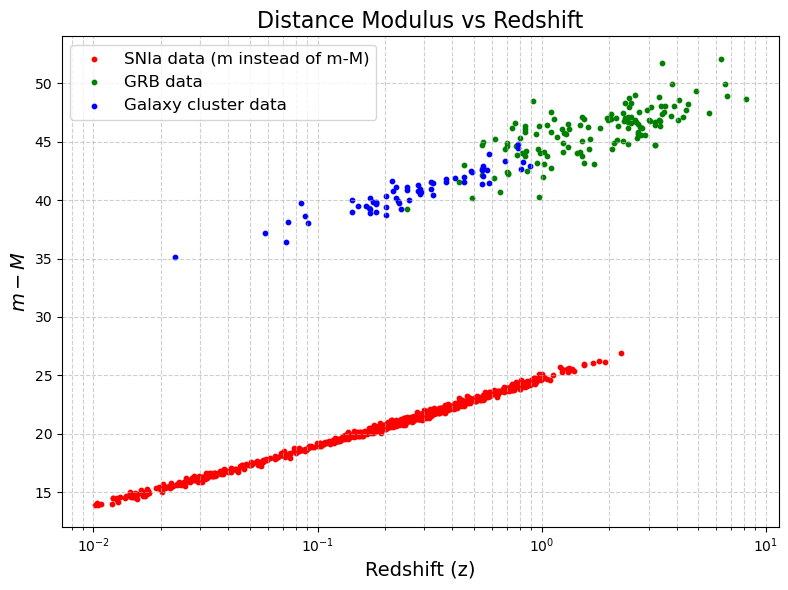

In [41]:
# Doing a 1000 runs but updating the initial parameters
estimates = np.zeros((1000, 5))
for i in range(1000):
    estimate = param_est(initial_params)
    estimates[i] = estimate
    initial_params = estimate
np.savetxt('estimate_combined_iter.txt',estimates)

plot_all(initial_params)